# Finetune on ATAC from mouse gastrulation

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns


import numpy as np
import torch 
import torch.nn as nn
import torch.nn.functional as F
import torch.multiprocessing as mp
from architecture_batchNorm_momentum import *
from finetuning_architecture import * 
from data_augmentation import *
from data_utils_finetuning import *

import pickle


/data/mikulik/miniconda3/envs/transformer/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-08-30 10:29:23.769813: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [50]:
odcf = False
if odcf:
    data_dir = "/omics/groups/OE0540/internal/users/mikulik/master_thesis/data/gcs_basenj/"
else:
    data_dir = "/data/mikulik/mnt/gcs_basenj/"
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using: {device}")
print(f"Number of GPUs available: {torch.cuda.device_count()}")



Using: cpu
Number of GPUs available: 0


Loading the fine-tuned model

In [3]:

pretrained_model = "basenji_paper_param_real_data_no_it_corr_0.15_sgd_4_augmentTrue_model_validation_checkpoint"
num_dilated_conv = 11
num_conv = 6
conv_target_channels = 768
dilation_rate_init = 1
bn_momentum = .9
dilation_rate_mult = 1.5
experiments_human = 5313
experiments_mouse = 1643
tracks=35
seq_length=131072
human_fasta_path=os.path.join(data_dir, "hg38.ml.fa")
mouse_fasta_path=os.path.join(data_dir, "mm10.ml.fa")

model = FineTuning(data_dir=os.path.join(data_dir, "basenji_output", "clean_slate"),
                            model_name=pretrained_model, 
                            tracks = tracks,                
                            num_conv=num_conv,
                            num_dilated_conv=num_dilated_conv,
                            conv_target_channels=conv_target_channels, 
                            bn_momentum=0.9, 
                            dilation_rate_init=dilation_rate_init, 
                            dilation_rate_mult=1.5, 
                            experiments_human=5313, 
                            experiments_mouse=1643)

In [61]:
print(f"Number of parameters of fine-tuned model jointly fine-tuned on ATAC-seq: {sum(p.numel() for p in model.parameters() if p.requires_grad)}")

Number of parameters of fine-tuned model jointly fine-tuned on ATAC-seq: 32672771


I performed several finetuning experiments on pseudobulk scATAC-seq data, using different batch size learning rate and otpimization algorithms. I will compare the outcome of the different experimetns here. As a metric I use the correlation across all positions between the predicted and the true signal.

In [4]:
save=False

if save:      
    corr_save={}                      
    for file in os.listdir(os.path.join(data_dir, "finetune_output")):
        if file.startswith("finetune_test") & file.endswith("model_validation_checkpoint.pt"):
            print(file)
            model.load_state_dict(torch.load(os.path.join(data_dir, "finetune_output", f"{file}")))#, map_location=torch.device("cpu")))#, strict=False)
            model.to(device)
            corr_vec = compute_correlation_basenji_norm(model, device, data_dir=data_dir,seq_length=seq_length,
                                    human_fasta_path=human_fasta_path, mouse_fasta_path=mouse_fasta_path, atac=True, rna=False, 
                                    rna_data="basenji2_gastrulation_dataset_rna_grcm3_final", log_transform_rna=False, batch_size=1,
                                    species="mouse", subset="test", n_channels=35, shuffle=False, max_steps=2017, per_track=True, gaussian_loss=False)
            print(corr_vec.mean())
            corr_save[file] = corr_vec
    with open(os.path.join(data_dir, "finetune_output", "atac_corr_lr_comp.pkl"), "wb") as f:
        pickle.dump(corr_save, f)

else: 
    with open(os.path.join(data_dir, "finetune_output", "atac_corr_lr_comp.pkl"), "rb") as f:
        corr_save = pickle.load(f)

In [7]:
atac_tar = pd.read_csv(os.path.join(data_dir, "atac_targets.txt"),sep=",", index_col=0, header=0)


In [9]:
corr_save.keys()

dict_keys(['finetune_test_0.0001_sgd_4_augmentFalse_model_validation_checkpoint.pt', 'finetune_test_0.01_sgd_4_augmentFalse_model_validation_checkpoint.pt', 'finetune_test_0.001_adam_4_augmentFalse_model_validation_checkpoint.pt', 'finetune_test_0.0001_adam_4_augmentFalse_model_validation_checkpoint.pt', 'finetune_test_0.01_adam_4_augmentFalse_model_validation_checkpoint.pt', 'finetune_test_0.001_sgd_4_augmentFalse_model_validation_checkpoint.pt', 'finetune_test_0.15_sgd_4_augmentFalse_model_validation_checkpoint.pt'])

Append the correlation values to the target df:

In [24]:
lr_dict = {}
for key, value in corr_save.items():
    name = key.split("finetune_test_")[1].split("_augmentFalse_model_validation_checkpoint.pt")[0]
    # append mean correlation value to hyperparameter dict
    lr_dict[name] = float(value.mean())
    # append correlation values for this hyperparameter set and each cell type to target df
    atac_tar[f"{name}_corr"] = value


In [33]:
d

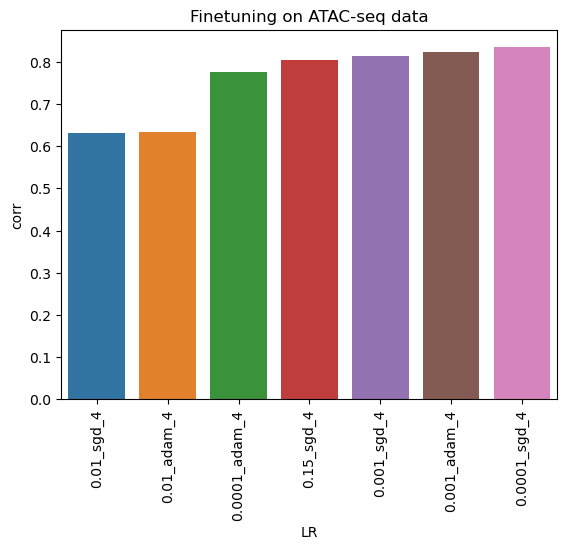

In [36]:
if save:
    plot_parameter_comparison(lr_dict, title="Finetuning on ATAC-seq data", save_pdf=os.path.join(data_dir, "plots/finetune_atac/",  'atac_finetune_lr_comparison.pdf'))
else: 
    plot_parameter_comparison(lr_dict, title="Finetuning on ATAC-seq data", save_pdf=None)

For the best performing model, in this case with the learning rate 0.0001, SGD and batch size 4 I will plot the correlation across positions as a function of the number of cells. It seems that there is no relationship between the number of representatives for a cell type (x-axis) and the correlation across postions between observed and predicted ATAC-seq signal (y-axis). When you remove any cell type with representatives above 3000, there seems to be a slight increase in correlation, but this would need to be studied with more cell types. 

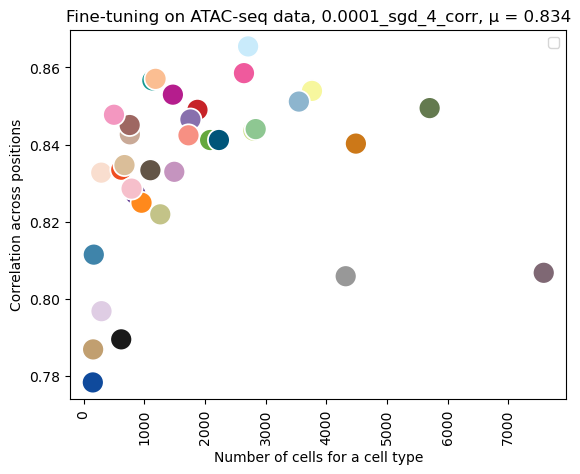

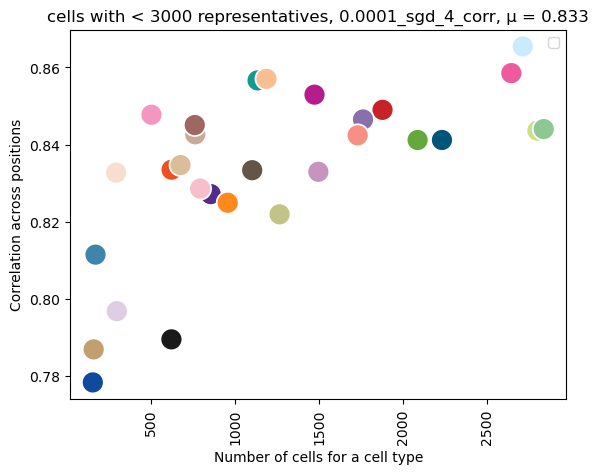

In [46]:
if save: 
    corr_vs_n_cells(atac_tar, model="0.0001_sgd_4_corr", ylabel="Correlation across positions",
                title="Fine-tuning on ATAC-seq data", save_pdf=os.path.join(data_dir, "plots/finetune_atac/",  'atac_finetune_0.0001_sgd_4_corr_n_scatter.pdf'))

else:
    corr_vs_n_cells(atac_tar, model="0.0001_sgd_4_corr", ylabel="Correlation across positions",
                title="Fine-tuning on ATAC-seq data", save_pdf=None)   

# remove any cells with more than 3000 representatives
atac_copy1 = atac_tar[atac_tar.n < 3000]
corr_vs_n_cells(atac_copy1, model="0.0001_sgd_4_corr", ylabel="Correlation across positions",
                title="cells with < 3000 representatives", save_pdf=None)   

Barplot for the best performing finetuned model:

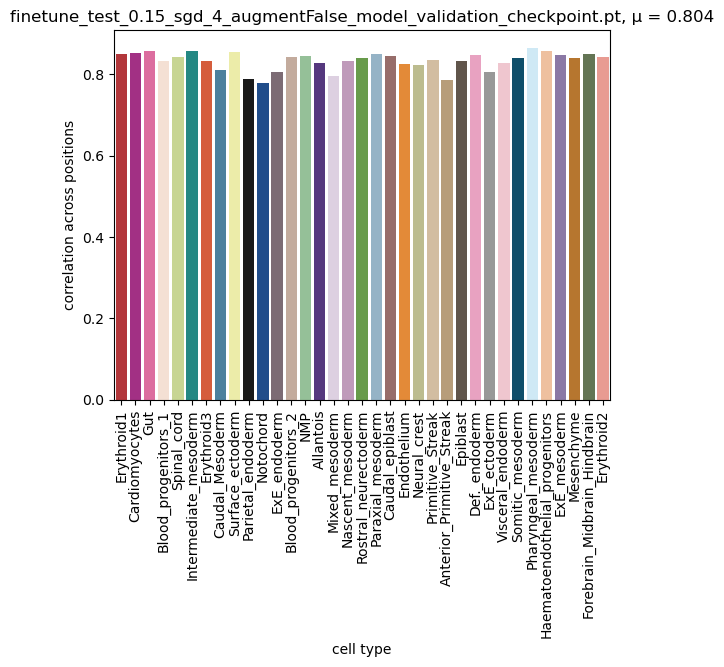

In [47]:

#atac_tar.sort_values("0.0001_sgd_4_corr", inplace=True)
sns.barplot(atac_tar, x="celltype", y="0.0001_sgd_4_corr", palette=atac_tar["color"])
#sns.barplot(data=atac_tar, x="celltype", y=f"{name}_corr", palette=atac_tar["color"])#, color="blue")
plt.title(f"{key}, µ = {value.mean():.3f}")
plt.xlabel("cell type")
plt.ylabel("correlation across positions")
plt.xticks(rotation=90)
plt.savefig(os.path.join(data_dir, "plots/finetune_atac/",  'atac_finetune_0.0001_sgd_4_corr.pdf'), format='pdf')
plt.show()

Below I visualize the correlation of each cell type across genes. The color of the bars indicate the cell type. Each separate plot represents correlations for different model hyperparameter sets.


In [ ]:

pattern = r'\d+\.\d+'
# initialize hyperparameter dict
lr_dict = {}
for key, value in corr_save.items():
    name = key.split("finetune_test_")[1].split("_augmentFalse_model_validation_checkpoint.pt")[0]
    
    # plot the correlation for each celltype across genes in the test set, colored by cell type
    sns.barplot(data=atac_tar, x="celltype", y=f"{name}_corr", palette=atac_tar["color"])
    plt.title(f"{key}, µ = {value.mean():.3f}")
    plt.xlabel("cell type")
    plt.ylabel("correlation across positions")
    plt.xticks(rotation=90)
    plt.show()




## Target tracks

I load the best performing finetuned model and plot the observed and predicted ATAC-seq signal for a few example test set regions.
In the plot below we can observe that whenever there is a lot of noise in the scATA-seq data, the model still predicts that certain regions are supposed to be important. 

In [55]:
model1 = FineTuning(data_dir,
                            model_name=pretrained_model, 
                            tracks = tracks,                
                            num_conv=num_conv,
                            num_dilated_conv=num_dilated_conv,
                            conv_target_channels=conv_target_channels, 
                            bn_momentum=0.9, 
                            dilation_rate_init=dilation_rate_init, 
                            dilation_rate_mult=1.5, 
                            experiments_human=5313, 
                            experiments_mouse=1643).to(device)

# load best performing model                            
model_scratch = "finetune_test_0.0001_sgd_4_augmentFalse_model_validation_checkpoint"
model_dir = os.path.join(data_dir, "finetune_output")
model1.load_state_dict(torch.load(os.path.join(model_dir, f"{model_scratch}.pt"), map_location=torch.device("cpu")))

dl = create_dataloader_gastr_norm(seq_length=131072,
                                atac=True, 
                                rna=False, 
                                data_dir=data_dir,
                                human_fasta_path=os.path.join(data_dir, "hg38.ml.fa"), 
                                mouse_fasta_path=os.path.join(data_dir, "mm10.ml.fa"), 
                                batch_size=1, 
                                log_transform_rna=False, 
                                shuffle=False, 
                                random=False, 
                                distributed_sampler=False)


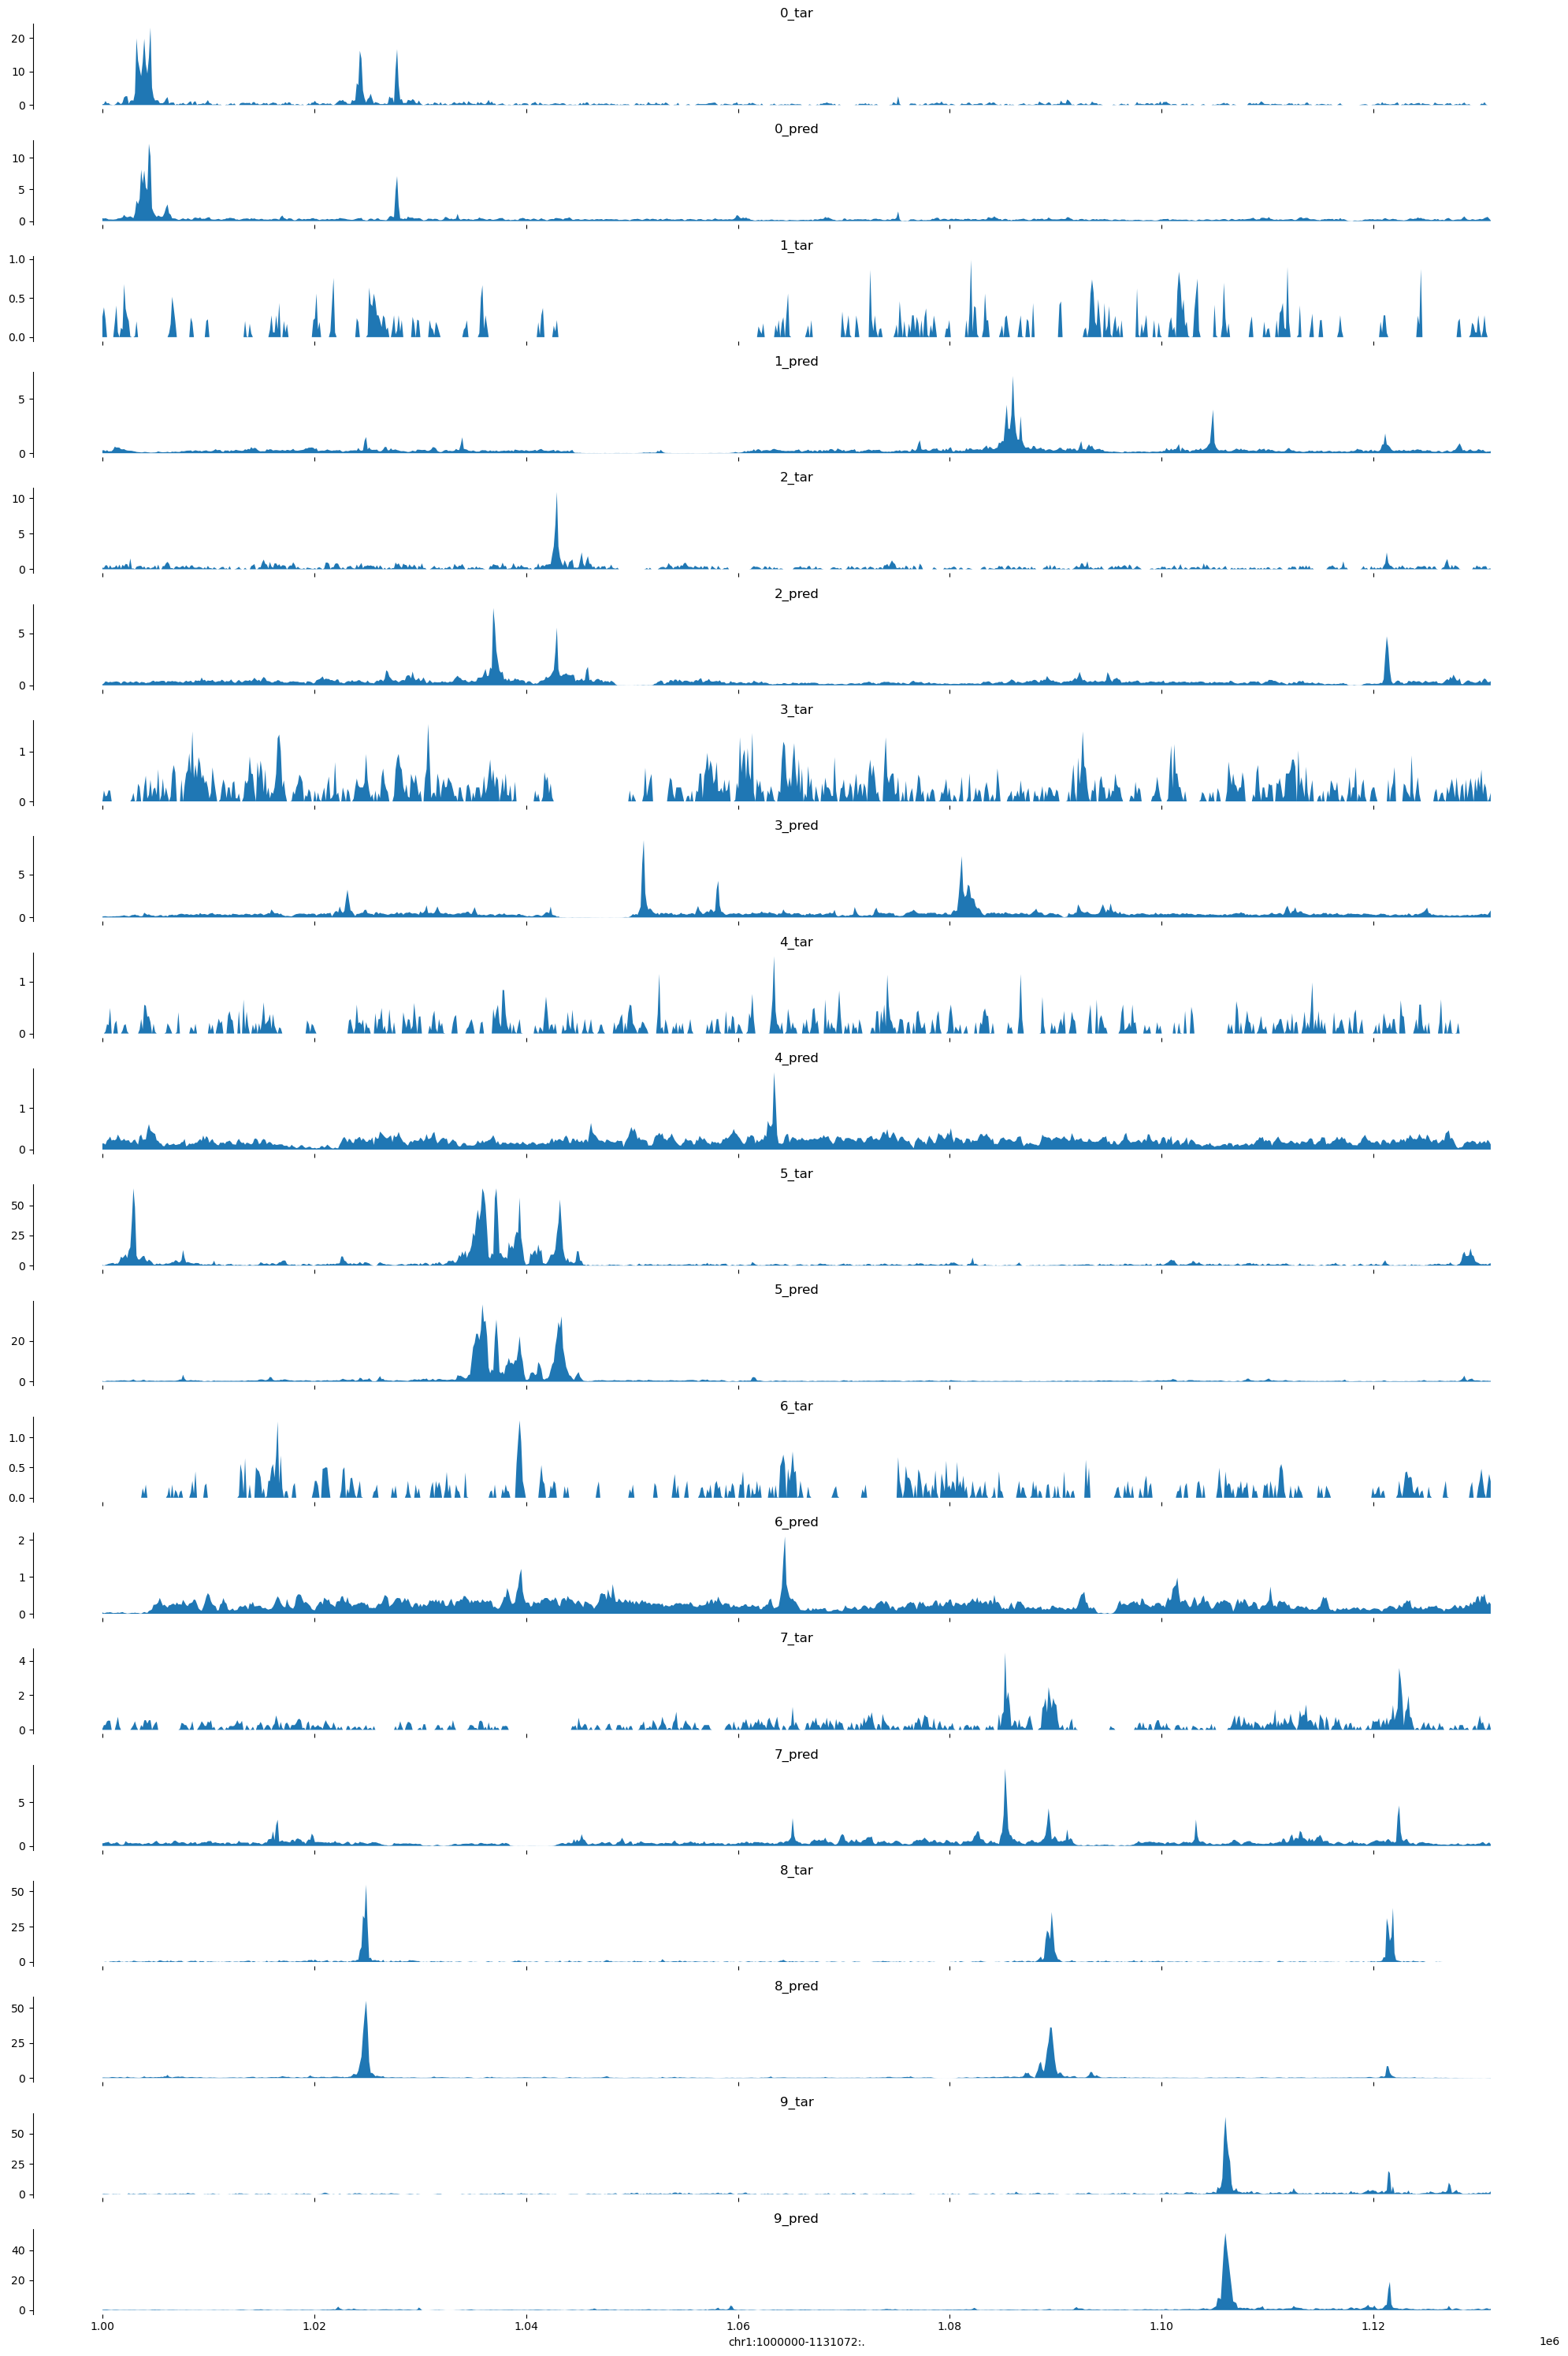

In [60]:
targets = {}
counts=0
for i, batch in enumerate(dl["test"]):
    counts+=1
    targets[f"{i}_tar"] = batch[1].squeeze()[:, 0]
    pred = model1(batch[0].to(device))
    targets[f"{i}_pred"] = pred.detach().numpy().squeeze()[:, 0]
    if counts >= 10:
        break

target_interval = kipoiseq.Interval(chrom="chr1", start=1000000, end=1000000+131072)
plot_tracks(targets, target_interval)